In [ ]:
# Importações necessárias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

In [ ]:
# verificação se há gpu disponível
print("GPU: ", len(tf.config.list_physical_devices('GPU')))
# É necessário usar a GPU, caso contrário, o treinamento vai demorar bastante

GPU:  1


In [ ]:
SEED = 123456 # semente para gerar aleatorios
os.environ['PYTHONHASHSEED']=str(SEED) # Ambiente para o python
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Ambiente para o tensorflow
random.seed(SEED) # python
np.random.seed(SEED) # numpy
tf.random.set_seed(SEED) # tensorflow

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # Carregamento dos dados
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

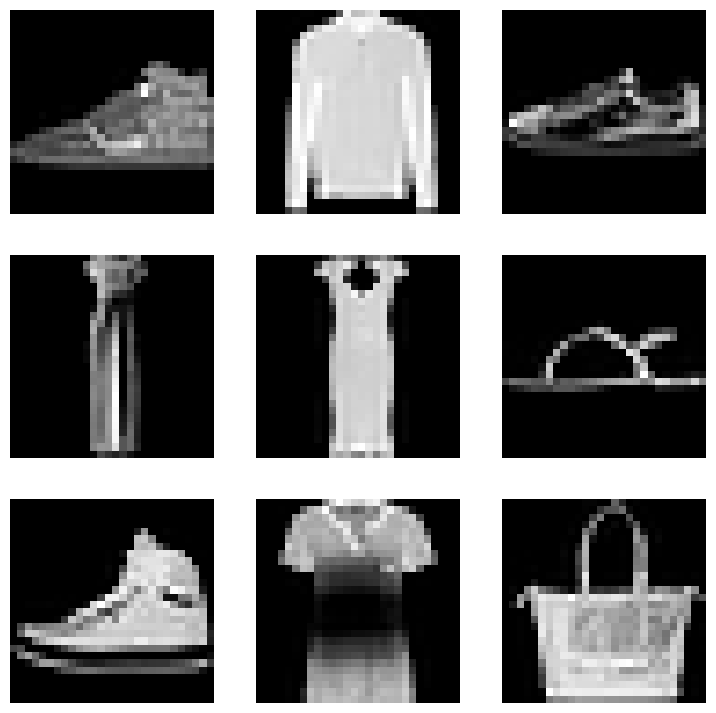

In [ ]:
plt.figure(figsize=(9,9)) # dimensoes da imagem
randSamples = np.random.choice(60000, 9) # Escolhe nove aleatórios
for i in range(9): # Percorre os escolhidos e plot
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[randSamples[i]], cmap='gray')
    plt.axis('off')

In [ ]:
# Como o problema não é de classificação, e sim de generação foi juntado novamente a base de dadso
dataset = np.concatenate((x_train, x_test), axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255.0 # Normalização

In [ ]:
# Criação de uma camada de sampling
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [ ]:
#encoder
def buildEncoder(latentDim, encoderInputs):

  # Bloco que vai extrair as caracteristicas
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])
  # passa as entradas pelo bloco convolucional
  x = l1(encoderInputs)
  # calculo da media
  zMean = layers.Dense(latentDim, name="z_mean")(x)
  # calculo da variancia
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)
  # aplicação da reparametrização
  z = SamplingLayer()([zMean, zLogVar])

  # retonra o modelo
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# constroi o modelo
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 256)            │        878,144 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer_1          │ (None, 2)              │              0 │ z_mean[0][0],          │
│ (SamplingLayer)           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# decoder
def buildDecoder(latentInputs):
  # bloco que vai reconstruir as caracteristicas
  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])
  # Retorna o modelo
  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# constroi o modelo
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 28, 28, 1)           │         157,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Função loss
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstructed),axis=(1, 2))
  )

In [ ]:
# Outra função loss
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(-0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),axis=1)
  )

In [ ]:
# Caclula a loss total, não pode haver duas
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [ ]:
# Criação de um modelo VAE
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # registra todas as loss para visualizar depois
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  # metricas para visualização
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # claculo do gradiente + loss + pesos
  def train_step(self, data):
    # recordação de todos os gradientes
    with tf.GradientTape() as tape:
        # segue
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # retorna
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # atualiza a loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # rertorna a loss
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) # Compilação
history = vae.fit(dataset, epochs=32, batch_size=128) # Treinamento com 32 epocas

Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - ce_loss: 252.5664 - kl_loss: 5.1960 - total_loss: 268.1544
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - ce_loss: 251.8155 - kl_loss: 5.2307 - total_loss: 267.5077
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - ce_loss: 251.5915 - kl_loss: 5.2180 - total_loss: 267.2455
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - ce_loss: 251.3384 - kl_loss: 5.2409 - total_loss: 267.0610
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - ce_loss: 251.2560 - kl_loss: 5.2322 - total_loss: 266.9527
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - ce_loss: 251.0093 - kl_loss: 5.2577 - total_loss: 266.7824
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - ce_loss: 250.8976 - kl_loss: 5.2495 - total_loss: 266.6461
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - ce_loss: 250.8838 - kl_loss: 5.2695 - total_loss: 266.6923
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - ce_loss: 250.9401 - kl_loss: 

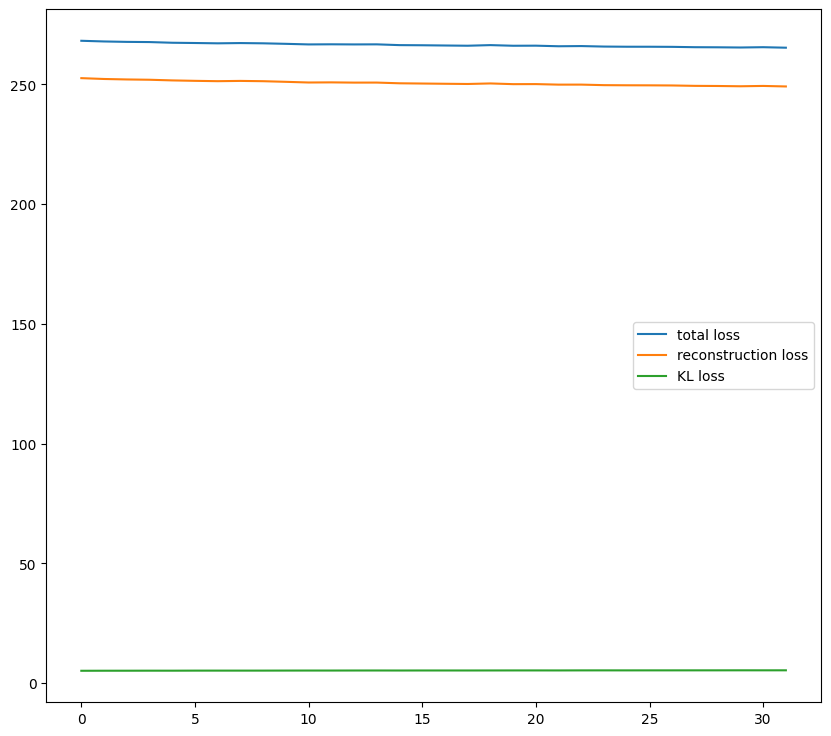

In [ ]:
# Plotando o historico da loss
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

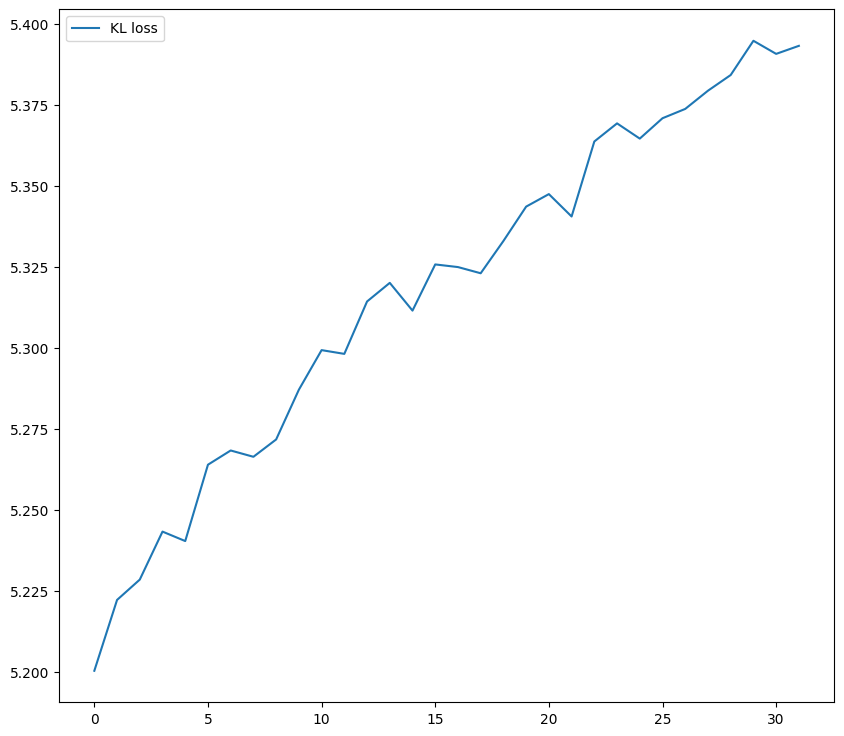

In [ ]:
# Plotando só a kl_loss
plt.figure(figsize=(10,9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


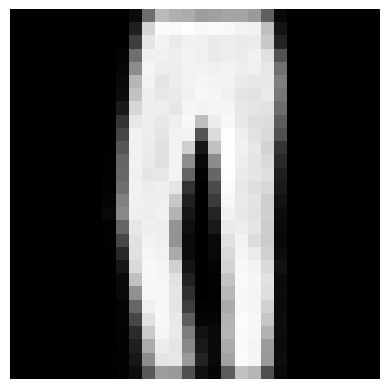

In [ ]:
synth = vae.decoder.predict(np.array([[1, 2]])) # Gera uma imagem
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r"); # mostra a imagem gerada

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


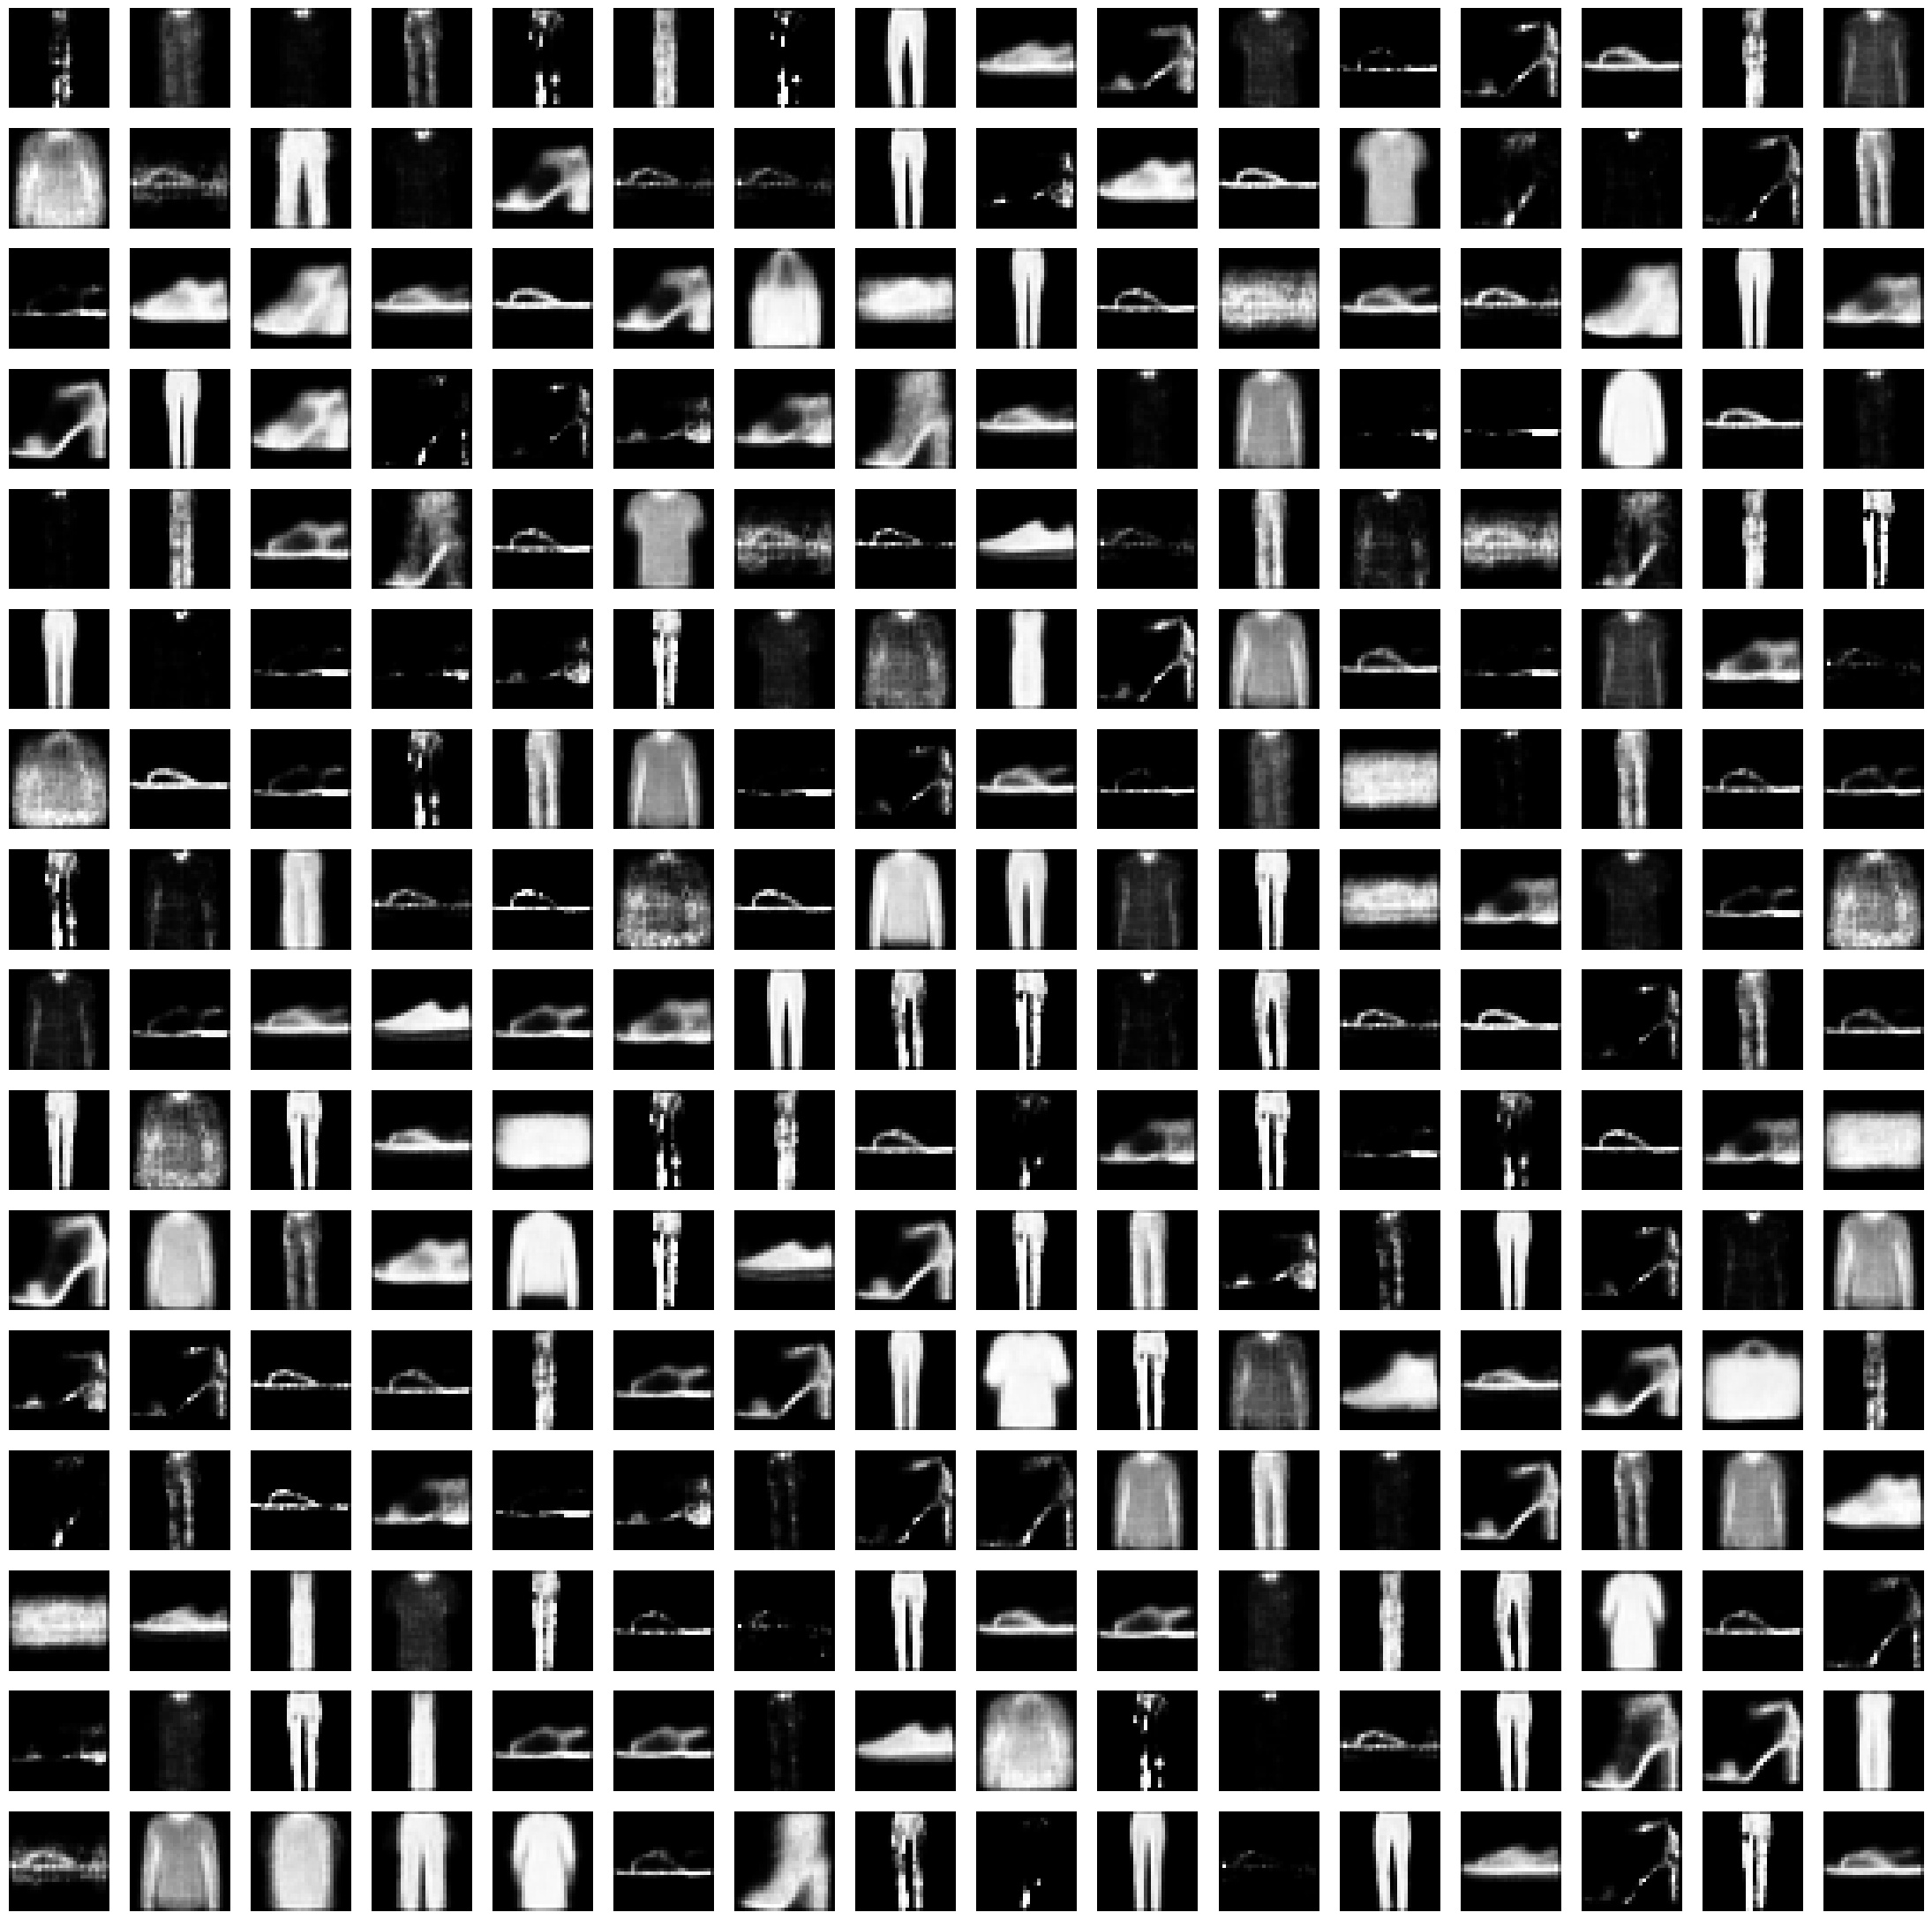

In [ ]:
z = np.random.normal(loc=0, scale=4, size=(256,2)) # escolha de 256 aleatórios
synth = vae.decoder.predict(z) # Geração desses 256
plt.figure(figsize=(28,28)) # Tamanho da imagem
for i in range(256): # plotando as 256
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')
plt.show();

In [ ]:
idx = 1280 # imagem aleatória número 1280 para geração de um tipo específico de roupa
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255 # normalização
print(batchOfImages.shape)
_, _, z = vae.encoder.predict(batchOfImages)
# reconstroi uma imagem similar
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[1.2276787 , 0.12807682]], dtype=float32)

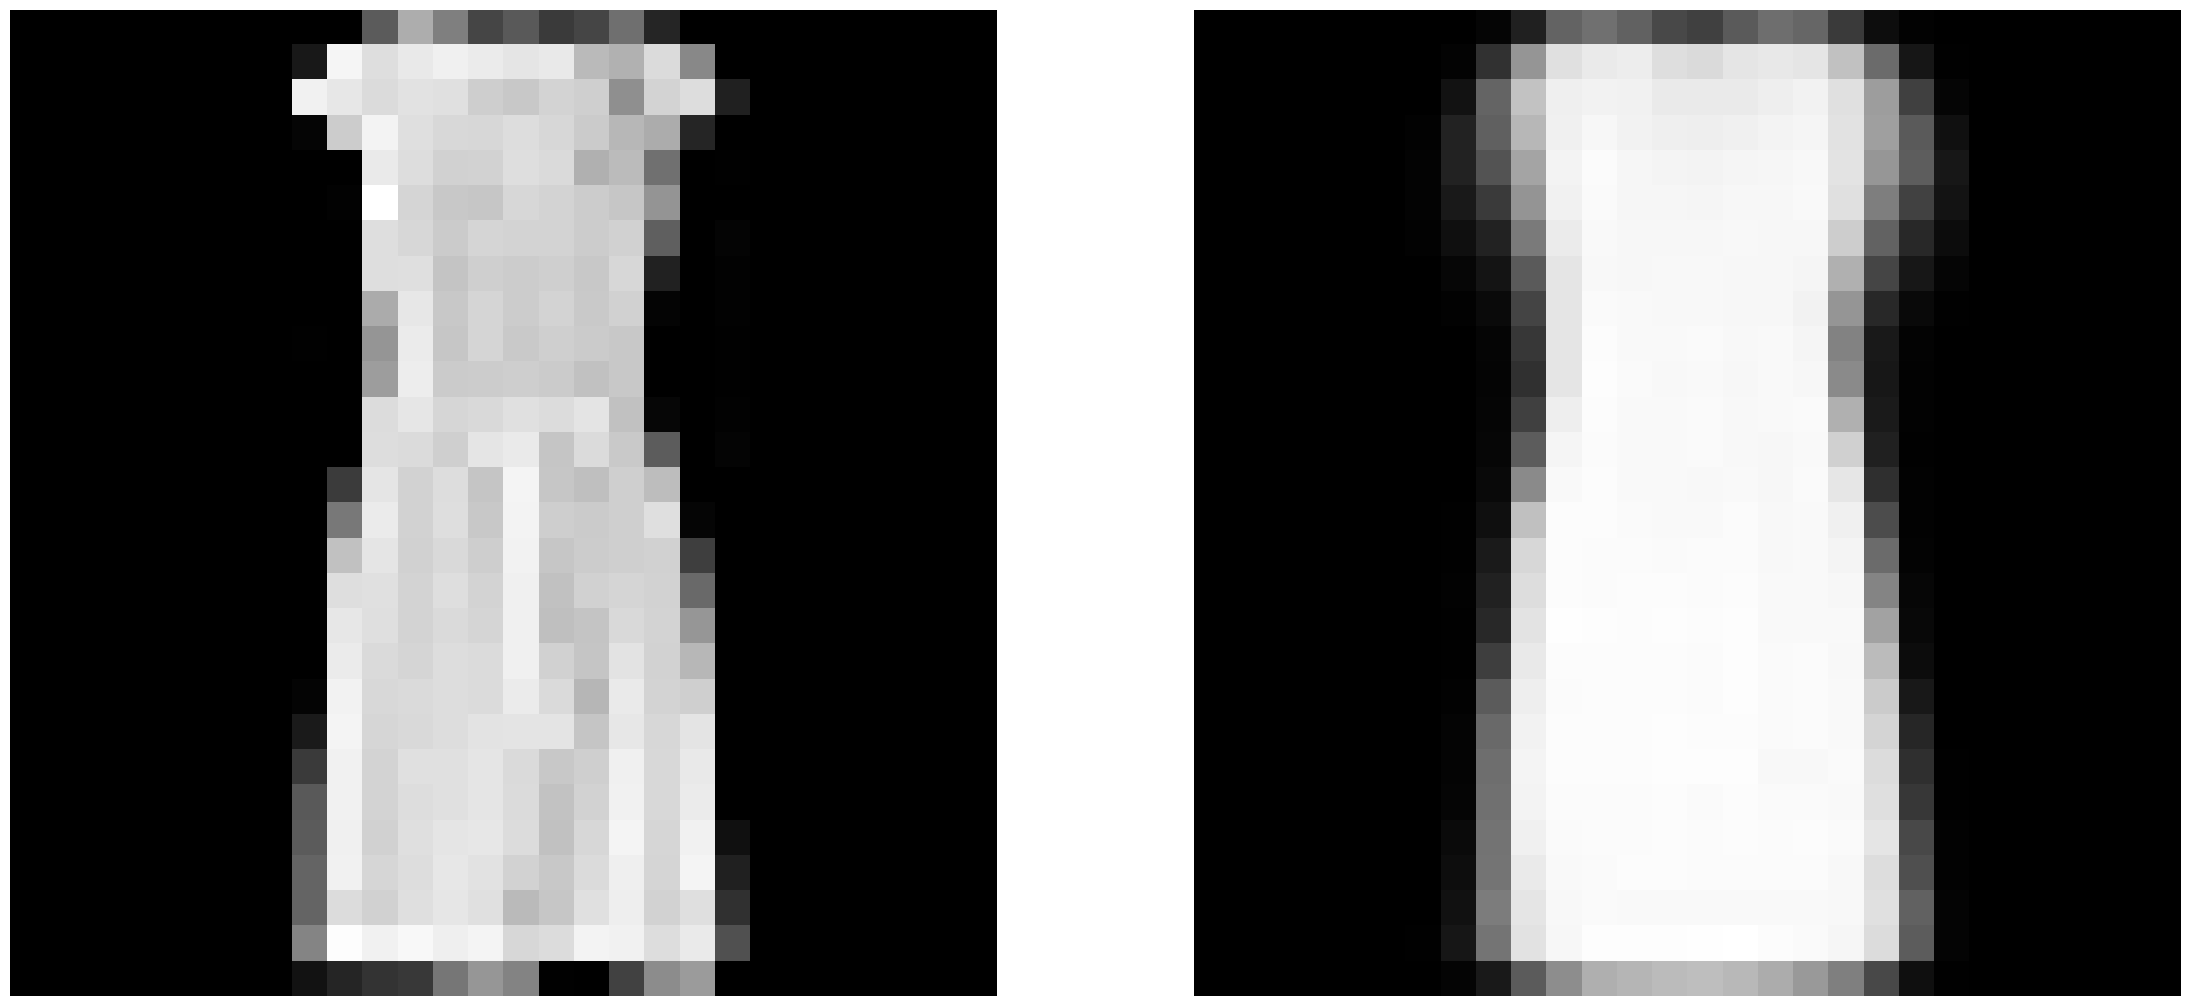

In [ ]:
plt.figure(figsize=(28, 28))

# mostra a imagem original
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# mostra a imagem gerada
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


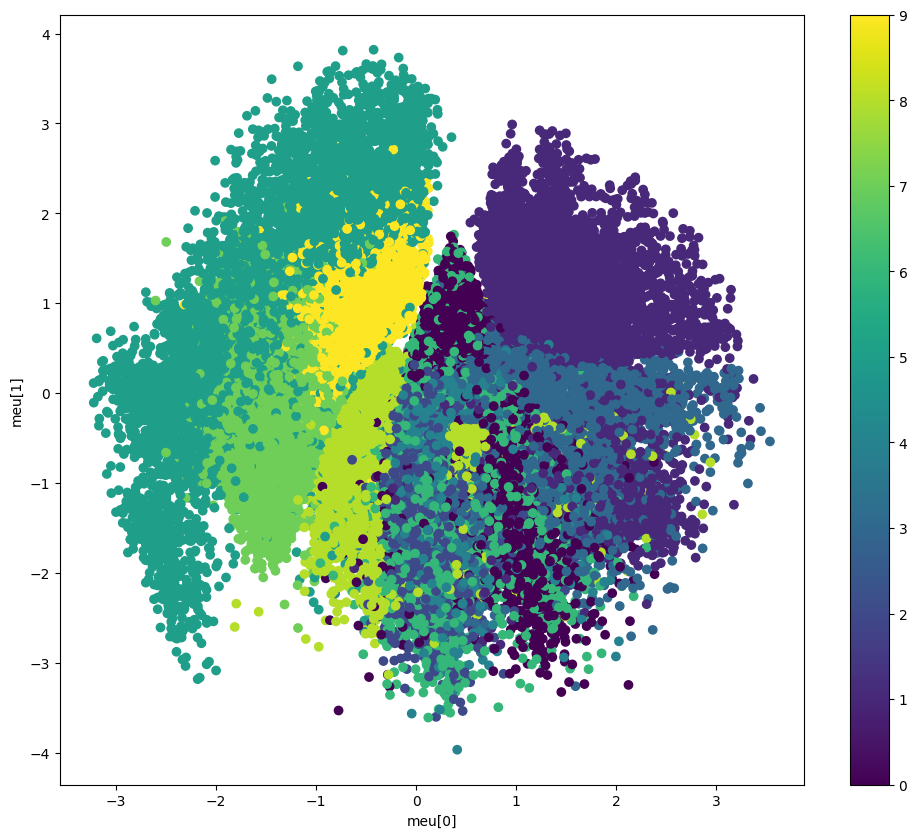

In [ ]:
"""
VAE can be used in unsupervised learning of large text or unlabeled images corpus
to cluster the samples into categories
"""
# Plotando a distribuições de probabilidade
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();